# Discriminative Word Analysis for Bankruptcy Prediction

This notebook performs a statistical analysis to identify the most discriminative words for **merged** and **not merged** cases in financial reports. The outcome can be used to build a simple rule-based filter and visualize performance metrics.

## 1. Setup and Imports
Clean code practices are followed: meaningful variable names, modular functions, and consistent formatting.

In [1]:
import sqlite3
import json
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

%matplotlib inline
# Configure plot aesthetics
plt.rcParams.update({'figure.figsize': (8, 5),
                     'axes.titlesize': 14,
                     'axes.labelsize': 12})

## 2. Data Loading
Connect to the SQLite database and load training and test sets based on `filing_date`.

In [2]:
DB_PATH = './data/database.db'  # Adjust path as needed
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

train_raw = cursor.execute(
    "SELECT sentences, label FROM embeddings WHERE filing_date < '2020-01-01';"
).fetchall()
test_raw = cursor.execute(
    "SELECT sentences, label FROM embeddings WHERE filing_date >= '2020-01-01';"
).fetchall()

# Parse JSON-encoded sentence lists
train_data = [(json.loads(s), lbl) for s, lbl in tqdm(train_raw, desc='Training')]
test_data = [(json.loads(s), lbl) for s, lbl in tqdm(test_raw, desc='Testing')]

Testing: 100%|██████████| 1027/1027 [00:00<00:00, 8525.94it/s]


## 3. Tokenization and Frequency Counting
We use a simple regex tokenizer: $$\mathrm{tokens} = \texttt{re.findall}(r"\\b\\w+\\b", text.lower())$$

### Standard Tokenization:

In [ ]:
# ## 3. Tokenization and Alphabetic Filtering
import re
from collections import Counter

# Only tokens with 3+ letters, no digits or symbols
VALID_TOKEN = re.compile(r'^[A-Za-z]{3,}$')

token_pattern = re.compile(r"\b\w+\b")
def tokenize(text: str) -> list[str]:
    """
    Split text into lowercase word tokens,
    then filter out any token that:
      - contains non-alphabetic characters
      - has length < 3
    """
    raw = token_pattern.findall(text.lower())
    return [tok for tok in raw if VALID_TOKEN.match(tok)]

# Split training sentences by label
merged_sents     = [s for sents, lbl in tqdm(train_data, desc='Merged Sentences') if lbl == 1 for s in sents]
not_merged_sents = [s for sents, lbl in tqdm(train_data, desc='Not-Merged Sentences') if lbl == 0 for s in sents]

# Count frequencies using filtered tokens only
merged_counts     = Counter(tok for s in tqdm(merged_sents, desc='Merged Token')     for tok in tokenize(s))
not_merged_counts = Counter(tok for s in tqdm(not_merged_sents, desc='Not-Merged Token') for tok in tokenize(s))

total_merged     = sum(merged_counts.values())
total_not_merged = sum(not_merged_counts.values())


### Endglish-Word Tokenization

In [3]:
# 3. Tokenization + English‐word filtering
import re
import nltk

# ensure WordNet is available
nltk.download('wordnet')
from nltk.corpus import wordnet

# only alphabetic tokens of length ≥3
ALPHA_TOKEN = re.compile(r'^[A-Za-z]{3,}$')

def is_english_word(tok: str) -> bool:
    """Check both form and dictionary membership."""
    return bool(ALPHA_TOKEN.match(tok)) and bool(wordnet.synsets(tok))

def tokenize(text: str) -> list[str]:
    """
    1) lowercase word‐character tokens
    2) keep only English words (≥3 letters, in WordNet)
    """
    raw = re.findall(r"\b\w+\b", text.lower())
    return [w for w in raw if is_english_word(w)]

# rebuild your counts using this tokenizer
merged_sents     = [s for sents, lbl in tqdm(train_data, desc='Merged Sentences') if lbl==1 for s in sents]
not_merged_sents = [s for sents, lbl in tqdm(train_data, desc='Not-Merged Sentences') if lbl==0 for s in sents]

from collections import Counter
merged_counts     = Counter(tok for s in tqdm(merged_sents, desc='Merged Token')     for tok in tokenize(s))
not_merged_counts = Counter(tok for s in tqdm(not_merged_sents, desc='Not-Merged Token') for tok in tokenize(s))

total_merged     = sum(merged_counts.values())
total_not_merged = sum(not_merged_counts.values())


[nltk_data] Downloading package wordnet to /home/cagatay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Not-Merged Token: 100%|██████████| 2026641/2026641 [04:56<00:00, 6831.95it/s]


## 4. Statistical Measure: Odds Ratio
We compute the **odds ratio** for each word $w$:

$$\mathrm{OR}(w) = \frac{P(w\mid \mathrm{merged})}{P(w\mid \mathrm{not\_merged})} = \frac{\frac{\mathrm{count}_{m}(w)}{\sum_w \mathrm{count}_{m}(w)}}{\frac{\mathrm{count}_{nm}(w) + 1}{\sum_w \mathrm{count}_{nm}(w)}}.$$

In [4]:
# Build DataFrame of words with their odds ratios
MIN_FREQ = 50  # Minimum total occurrences filter

records = []
for word, m_cnt in merged_counts.items():
    nm_cnt = not_merged_counts.get(word, 0)
    if (m_cnt + nm_cnt) < MIN_FREQ:
        continue
    # Odds Ratio formula:
    #   OR(w) = (m_cnt/total_merged) / ((nm_cnt+1)/total_not_merged)
    oratio = (m_cnt/total_merged) / ((nm_cnt + 1)/total_not_merged)
    records.append((word, m_cnt, nm_cnt, oratio))

df_stats = pd.DataFrame(
    records,
    columns=["word", "merged_count", "not_merged_count", "odds_ratio"]
)


## 5. Top Discriminative Words
- **For merged**: highest odds ratios.
- **For not merged**: highest inverse odds ratios.

In [5]:
# Top 20 for Merged
df_top_merged    = df_stats.sort_values("odds_ratio", ascending=False).head(20)
# Top 20 for Not-Merged (invert)
df_stats["inv_odds"] = 1/df_stats["odds_ratio"]
df_top_notmerged   = df_stats.sort_values("inv_odds", ascending=False).head(20)

# Display
print("### Top 20 Discriminative Words for Merged")
display(df_top_merged)
print("### Top 20 Discriminative Words for Not Merged")
display(df_top_notmerged)

### Top 20 Discriminative Words for Merged


,word,merged_count,not_merged_count,odds_ratio
10061,occupier,98,29,15.813424
8971,zion,45,15,13.614874
9966,ignite,61,24,11.811659
6523,cisco,526,258,9.831212
6539,router,87,42,9.794266
8070,oracle,523,266,9.482253
6563,initiations,42,22,8.839802
8310,firethorn,36,19,8.713519
6514,switches,187,111,8.082481
577,keynote,87,52,7.946291


### Top 20 Discriminative Words for Not Merged


,word,merged_count,not_merged_count,odds_ratio,inv_odds
10202,retailed,1,580,0.008332,120.020392
10147,hectoliter,1,521,0.009274,107.832435
10343,sheep,1,336,0.014365,69.615959
10037,uniforms,1,277,0.017413,57.428002
10243,guy,1,225,0.021420,46.686073
8302,slot,1,225,0.021420,46.686073
9998,homer,2,436,0.022155,45.136757
10014,authentication,1,201,0.023965,41.728260
10004,reservations,10,1977,0.024473,40.860643
9540,macau,12,2359,0.024614,40.626524


## 6. Visualization of Top Words
Bar plots of odds ratios for the top discriminative words.

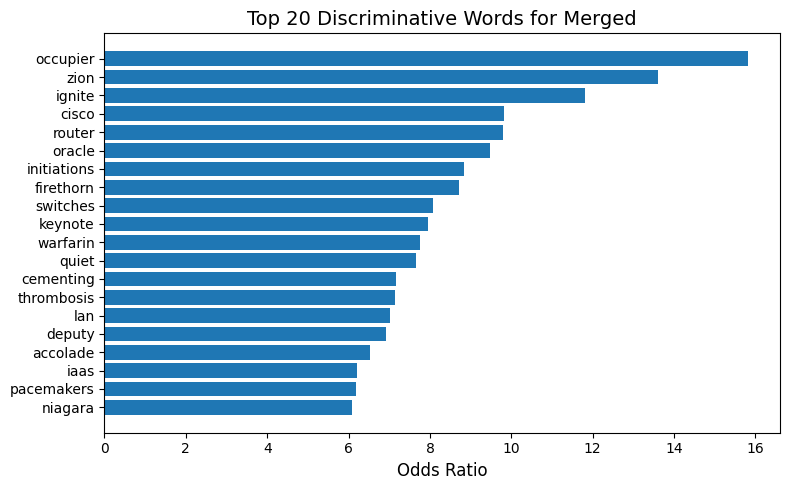

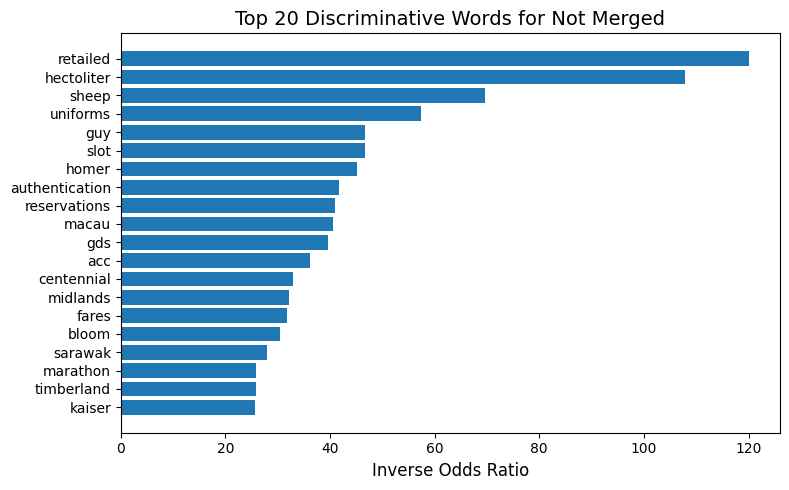

In [6]:
# Plot for merged
plt.figure()
plt.barh(df_top_merged['word'][::-1], df_top_merged['odds_ratio'][::-1])
plt.xlabel('Odds Ratio')
plt.title('Top 20 Discriminative Words for Merged')
plt.tight_layout()
plt.show()

# Plot for not merged
plt.figure()
plt.barh(df_top_notmerged['word'][::-1], df_top_notmerged['inv_odds'][::-1])
plt.xlabel('Inverse Odds Ratio')
plt.title('Top 20 Discriminative Words for Not Merged')
plt.tight_layout()
plt.show()

## 7. Rule-based Filter and Performance
Classify a report as merged if it contains any of the top merged words.

### Word Count Classifer

Classify: 100%|██████████| 1027/1027 [00:45<00:00, 22.45it/s]

=== Word Counter Classifer ===
Accuracy:        0.8257059396299903
Precision:       0.1956521739130435
Recall:          0.059602649006622516
F1-score:        0.09137055837563451
TP: 9.000
TN: 839.000
FP: 37.000
FN: 142.000


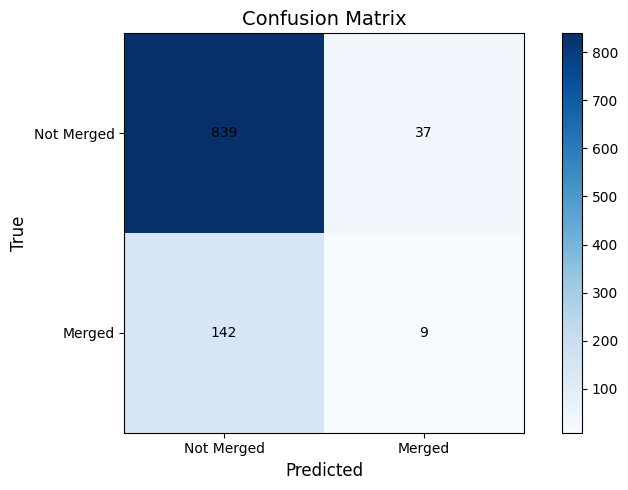

In [7]:
# Define filter function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def classify_report(sentences):
    tokens = {tok for s in sentences for tok in tokenize(s)}
    return int(bool(tokens & set(df_top_merged['word'])))

# Evaluate on test set
y_true = [lbl for sents, lbl in test_data]
y_pred = [classify_report(sents) for sents, lbl in tqdm(test_data, desc='Classify')]

# Metrics
print("=== Word Counter Classifer ===")
print("Accuracy:       ", accuracy_score(y_true, y_pred))
print("Precision:      ", precision_score(y_true, y_pred))
print("Recall:         ", recall_score(y_true, y_pred))
print("F1-score:       ", f1_score(y_true, y_pred))
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("TP: {:.3f}".format(tp))
print("TN: {:.3f}".format(tn))
print("FP: {:.3f}".format(fp))
print("FN: {:.3f}".format(fn))

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['Not Merged','Merged'])
plt.yticks([0,1], ['Not Merged','Merged'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


### Average-score-based classifier

Classify: 100%|██████████| 1027/1027 [00:46<00:00, 22.09it/s]

=== Average-score-based classifier ===
Accuracy:        0.8276533592989289
Precision:       0.25
Recall:          0.08609271523178808
F1-score:        0.12807881773399016
TP: 13.000
TN: 837.000
FP: 39.000
FN: 138.000


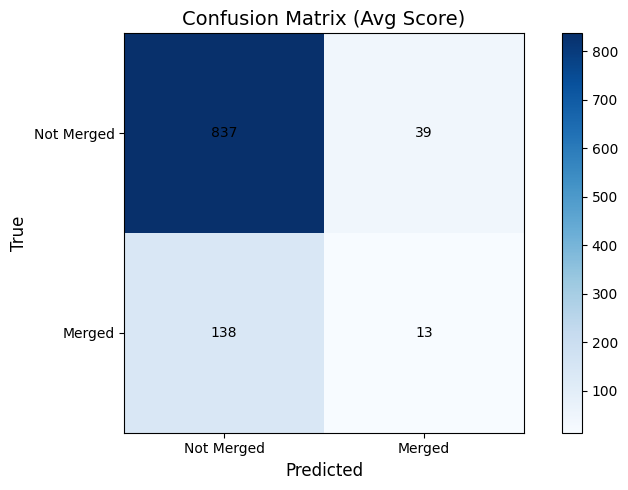

In [8]:
word_scores = df_stats.set_index('word')['odds_ratio'].to_dict()
th = df_stats['odds_ratio'].mean()
def avg_score_classifier(sentences: list[str], threshold: float = 1.0) -> int:
    """
    Compute the average odds-ratio score across all tokens in the report.
    Classify as 'merged' (1) if avg_score > threshold, else 'not merged' (0).
    """
    tokens = [tok for s in sentences for tok in tokenize(s)]
    scores = [word_scores[t] for t in tokens if t in word_scores]
    if not scores:
        # no known tokens → default to not merged
        return 0
    avg_score = sum(scores) / len(scores)
    return int(avg_score > threshold)

# Evaluate on the test set
y_true = [lbl for sents, lbl in test_data]
y_pred = [avg_score_classifier(sents, threshold=th) for sents, lbl in tqdm(test_data, desc='Classify')]

# Metrics
print("=== Average-score-based classifier ===")
print("Accuracy:       ", accuracy_score(y_true, y_pred))
print("Precision:      ", precision_score(y_true, y_pred))
print("Recall:         ", recall_score(y_true, y_pred))
print("F1-score:       ", f1_score(y_true, y_pred))
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("TP: {:.3f}".format(tp))
print("TN: {:.3f}".format(tn))
print("FP: {:.3f}".format(fp))
print("FN: {:.3f}".format(fn))

# Plot confusion matrix
# Compute performance
cm_avg = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm_avg, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix (Avg Score)")
plt.colorbar()
plt.xticks([0,1], ['Not Merged','Merged'])
plt.yticks([0,1], ['Not Merged','Merged'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_avg[i,j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
